In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import numpy as np
import os
from matplotlib import pyplot as plt
import matplotlib as mpl
from time import time
from munch import Munch

from itertools import count
from matplotlib import colors

from FKMC.general import index_histogram_array, sort_IPRs, smooth
from FKMC.import_funcs import get_data_structured

%matplotlib inline
np.seterr(all='warn')
textwidth = 6.268
mpl.rcParams['figure.dpi'] = 70
default_figargs = dict(figsize = (textwidth,textwidth))

import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING) 

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [3]:
board = np.zeros((10,10))
board[5,5] = 1

def transition(board):
    new_board = np.zeros_like(board)
    N, M = board.shape
    for i in range(N):
        for j in range(M):
            cell = board[i,j]
            if cell == 0: continue
                
            for i2 in [-1,0,1]:
                for j2 in [-1,0,1]:
                    if 0<=(i+i2)<N and 0<=(j+j2)<M:
                        new_board[i+i2, j+j2] += cell * 1/9
                    else:
                        new_board[i, j] += cell * 1/9
    return new_board
                    
            
def transitions(board, num):
    for i in range(num):
        board = transition(board)
    return board

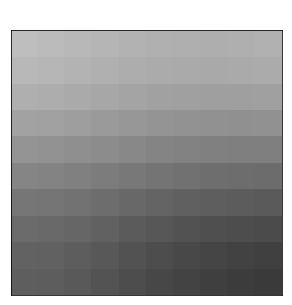

In [9]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

norm = colors.Normalize(vmin=0, vmax=2 / board.size)
f, ax = plt.subplots(1,1, figsize = (5,5), sharey = 'row')
ax.set(yticks = [], xticks = [])

frames = range(40)

def init():
    global cs, text
    cs = ax.pcolormesh(board, cmap='binary', norm = norm)
    text = ax.text(0,1.05, f' ', fontsize = 15, transform=ax.transAxes)
    return cs, text

def update(frame):
    global board, cs
    
    if frame == 0:
        board = np.zeros((10,10))
        board[2,5] = 1
    else:
        board = transitions(board, 1)
        
    cs.set_array(board[:, :].ravel())
    text.set_text(f'{frame}')
    if frame == frames[-1]: text.set_text(f' ')
    
    return cs, text

ani = FuncAnimation(f, update, frames=frames,
                    init_func=init, blit=True,
                    repeat_delay = 1000,
                   interval = 200,)
ani.save('MCMC_ensemble.mp4', dpi = 300)
HTML(ani.to_html5_video())

In [11]:
board = np.zeros((10,10))
state = (5,5)

def transition_with_state(board, state):
    #move the state
    N, M = board.shape
    i, j = state
    i2 = np.random.choice([-1,0,1])
    j2 = np.random.choice([-1,0,1])

    if 0<=(i+i2)<N and 0<=(j+j2)<M:
        new_state = ((i + i2), (j + j2))
    else:
        new_state = state
    
    board[new_state] += 1
    return board, new_state    

def transitions_with_state(board, state, num):
    for i in range(num):
        board, state = transition_with_state(board, state)
    return board, state

100.0 16.0 0.0


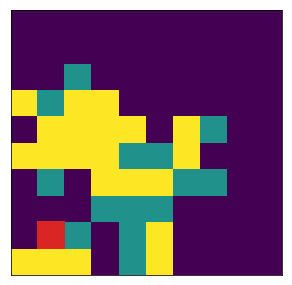

In [12]:
board, state = transitions_with_state(board, state, 100)

print(board.sum(), board.max(), board.min())

f, ax = plt.subplots(1,1, figsize = (5,5), sharey = 'row')
ax.set(yticks = [], xticks = [])

overlay = np.ma.array(0.7*np.ones_like(board), mask = np.ones_like(board))
overlay.mask[state] = 0

plot_board = board[:, :] / board.sum()
plot_board[state] = 1
ax.pcolormesh(plot_board, vmin = 0, vmax = 2 / board.size)
ax.pcolormesh(overlay, vmin = 0, vmax = 1, cmap='Reds')


init called
init called
init called


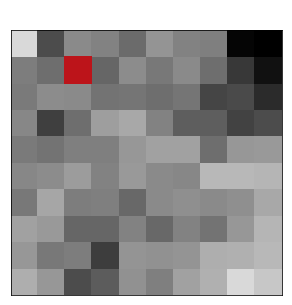

In [13]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

norm = colors.Normalize(vmin=0, vmax=2 / board.size)
f, ax = plt.subplots(1,1, figsize = (5,5), sharey = 'row')
ax.set(yticks = [], xticks = [])

board = np.zeros((10,10))
state = (5,5)
plot_board = board[:, :] / board.sum()
plot_board[state] = 1
frames = range(5000)

overlay = np.ma.array(0.8*np.ones_like(board), mask = np.ones_like(board))

def init():
    print('init called')
    global cs, text, state, ov, cbar
    cs = ax.pcolormesh(plot_board, cmap='binary', norm = norm)
    ov = ax.pcolormesh(overlay, vmin = 0, vmax = 1, cmap='Reds')
    text = ax.text(0,1.05, f' ', fontsize = 15, transform=ax.transAxes)
    
    #cbar = f.colorbar(cs, ax=ax, extend='both')
    #cbar.minorticks_on()
    
    return cs, text, ov

def update(frame):
    global board, cs, state, frames
    
    if frame == 0:
        board = np.zeros((10,10))
        state = (2,2)
    else:
        board, state = transitions_with_state(board, state, 1)
        
    s = board.sum() if board.sum() > 0 else 1
    plot_board = board[:, :] / s
    plot_board[state] = 1    
    
    overlay.mask = np.ones_like(board)
    overlay.mask[state] = 0
    
    cs.set_array(plot_board[:, :].ravel())
    ov.set_array(overlay[:, :].ravel())
    
    text.set_text(f'{frame}')
    if frame == frames[-1]: text.set_text(f' ')
    
    return cs, text, ov

ani = FuncAnimation(f, update, frames=frames,
                    init_func=init, blit=True,
                   repeat_delay = 500,
                   interval = 10,
                   )
ani.save('./MCMC_indiv.mp4', dpi = 300)
HTML(ani.to_html5_video())